# 5+n simple tricks to improving VAES
### Important: Get kagggle.json before running the notebook
Follow [these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to get a kaggle.json key file. Then upload it to colab.


In [1]:
# @title Setup for colab { display-mode: "form" }

%%capture
!sudo apt-get install subversion
!svn checkout https://github.com/probml/pyprobml/trunk/vae .
!pip install pytorch-lightning einops
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/download_celeba.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/two_stage_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/hinge_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/info_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/logcosh_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/mmd_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vanilla_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/sigma_vae_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/vq_vae_celeba_conv.ckpt
!wget -q https://storage.googleapis.com/probml_data/vae_checkpoints/pixel_cnn_celeba_conv.ckpt

A VAE is a type of deep latent model that is trained by maximising the likelihood or evidence by maximising a more tractable lower bound known as the evidence lower bound (ELBO)

$$\log p_\theta(x) \stackrel{\text{Jensen   Inequality}}{\geq} \mathbb{E}_{q(z\mid x)}[\log p_\theta(x\mid z)] - \mathbb{KL}(q(z\mid x) \mid\mid p_\theta(z)) \\ = \frac{1}{2}||\hat{x} - x||^2- \mathbb{KL}(q(z\mid x) \mid\mid p_\theta(z)) \text{ (for Guassian prior VAE)} $$

An intuitive way of understanding the above loss function is to break it into 2 parts the reconstruction loss (i.e. least-square/MSE part) and the KL term. The reconstruction term attempts to reconstruct the original image, but the KL term ensures that the intermediate layer has some structure. A simple modification to this setup is beta-VAE, which adds a beta term to the ELBO, allowing us to specify how strong we want the KL term/ prior influence to be on the VAE. 

$$\mathbb{E}_{q(z\mid x)}[\log p_\theta(x\mid z)] - \beta*\mathbb{KL}(q(z\mid x) \mid\mid p_\theta(z)) \\ = \frac{1}{2}||\hat{x} - x||^2- \beta*\mathbb{KL}(q(z\mid x) \mid\mid p_\theta(z)) \text{ (for Guassian prior VAE)}$$

This provides a simple way of improving the sample quality and reconstruction by tuning the beta term in the loss function of our VAE.  However, this can often require **many** attempts of trial and error to find the right beta term for our current VAE architecture and dataset. Furthermore, the beta term doesn't control only one factor. It also controls the quality of the latent space learnt and how well the VAE generalises. As such, these different goals come into conflict when trying to tune the beta term of beta-VAE; for example, increasing the beta term often leads to better generalisation and a more disentangled latent space but at the cost of blurrier samples and reconstruction.

In [ ]:
# @title Import Libraries and defining helper function { display-mode: "form" }

import torch
import warnings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from scipy.stats import truncnorm
from scipy.stats import norm
from sklearn.manifold import TSNE
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from download_celeba import celeba_dataloader
from assembler import get_config, assembler
from utils.plot import plot_reconstruction, plot_samples
from utils.interpolation import vector_of_interest, get_imrange
from experiment import VAEModule, VAE2stageModule

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def make_model(model_name, use_gpu=False):
    fname = f"./configs/{model_name}.yaml"
    config = get_config(fname)
    vae = assembler(config, "inference")
    if use_gpu:
        vae = vae.to("cuda")
    return vae


def make_and_load_models(model_names: list, use_gpu=False):
    vaes = []
    for model_name in model_names:
        vae = make_model(model_name, use_gpu)
        vae.load_model()
        vaes.append(vae)
    return vaes

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# @title Download celeba and load datamodule { display-mode: "form" }

!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!rm kaggle.json
!python download_celeba.py

bs = 512
IMAGE_SIZE = 64
CROP = 128
lr = 1e-3
epochs = 1
latent_dim = 256
DATA_PATH = "kaggle"

dm = celeba_dataloader(bs, IMAGE_SIZE, CROP, DATA_PATH)
dm.setup()  # force make data loaders n

batch = next(iter(dm.train_dataloader()))
x, y = batch

 99% 1.32G/1.33G [00:27<00:00, 48.1MB/s]
100% 1.33G/1.33G [00:27<00:00, 51.0MB/s]
  0% 0.00/2.02M [00:00<?, ?B/s]
100% 2.02M/2.02M [00:00<00:00, 180MB/s]
  0% 0.00/1.54M [00:00<?, ?B/s]
100% 1.54M/1.54M [00:00<00:00, 171MB/s]
  0% 0.00/466k [00:00<?, ?B/s]
100% 466k/466k [00:00<00:00, 154MB/s]
  0% 0.00/2.07M [00:00<?, ?B/s]
100% 2.07M/2.07M [00:00<00:00, 154MB/s]
Done!
I0817 01:48:14.942207 139717319116672 utils.py:157] NumExpr defaulting to 2 threads.
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, othe

## 1. Use sigma VAE to tune your beta term

One way to find a good starting point is to tune our beta term (i.e. a good initial beta) using sigma VAEs. The idea of sigma VAEs is to add a variance term to the front of the MSE term resulting in the following ELBO

$$ELBO = \mathbb{E}_{q(z\mid x)}[\log p_\theta(x\mid z)] - \mathbb{KL}(q(z\mid x) \mid\mid p_\theta(z)) \\ = \frac{1}{2\sigma^2}||\hat{x} - x||^2 + D\ln \sigma + c - \mathbb{KL}(q(z\mid x) \mid\mid p_\theta(z)) \text{ (for Guassian prior VAE)}$$

<center>
<img src="https://i.imgur.com/ixkfX86.png"
 style="float:right;width:50px;height:50px;">
 <p>Figure 1: Different beta and their corresponding images generated by VAE learnt using that beta value, from <a src="https://arxiv.org/pdf/2006.13202.pdf">Rybkin, O. et al. 21</a></p>
</center>
The sigma term accounts for the different variances in the posterior distribution. It is computed using batch statistics rather than the sigma term computed by the posterior network to reduce training instability. 

**Disclaimer**: Difference between the paper results and the obtained results might be due to architectural differences and different number of training epochs, the main point is that sigma-VAE is able to achieve good samples for a VAE without much hyperparameters. 

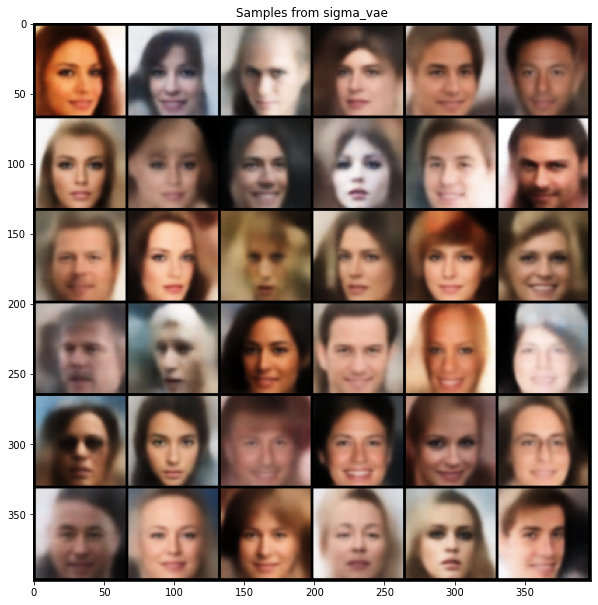

In [ ]:
num_imgs = 36
num_of_images_per_row = 6
figsize_samples = (10, 10)

vaes = make_and_load_models(["sigma_vae"], use_gpu=True)
plot_samples(vaes, num=num_imgs, num_of_images_per_row=num_of_images_per_row)

## 2. Use logcosh VAE to generate sharper images

Another possible modification to the typical loss of the VAE is to replace the MSE term at the start with another loss function. The main issue with the MSE loss is that the MSE term penalizes small errors too lightly. This makes the objective function overly dominated by the second term (the KL divergence term). One approach to tackling this is to tune the beta term in our objective function, but this is tricky, as discussed previously. Another approach to tackling this is to clip the gradient of the loss function with an upper bound so that the reconstruction penalty does not always increase linearly with the error. A smooth approximation of this is the tanh function, whose integral turns out to be the log-cosh function. The resulting log-cosh loss becomes more sensitive to small errors but doesn't overly penalise when the reconstruction error is large.

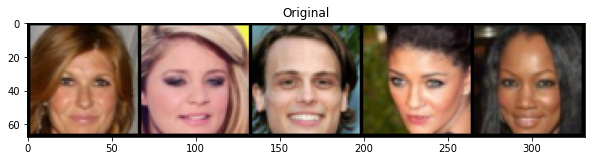

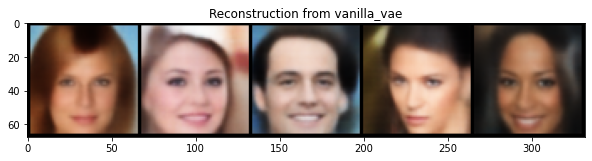

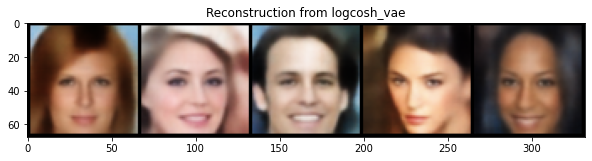

In [ ]:
models_to_compare = ["vanilla_vae", "logcosh_vae"]
figsize_reconstruction = (10, 30)
num_imgs = 5

vaes = make_and_load_models(models_to_compare, use_gpu=True)
plot_reconstruction(vaes, batch, num_of_samples=num_imgs)

## 3. Use 2 stage VAE to create samples with fewer artefacts

One weakness with VAE is that they might learn the underlying manifold but not the correct probability measure on that manifold. This was shown theoretically in [Dai et al. 19](https://arxiv.org/pdf/1903.05789.pdf) to occur for gaussian VAE. As a result, when sampling from the VAE, we might sample what is actually a low probability region resulting in samples with a lot of artefacts.

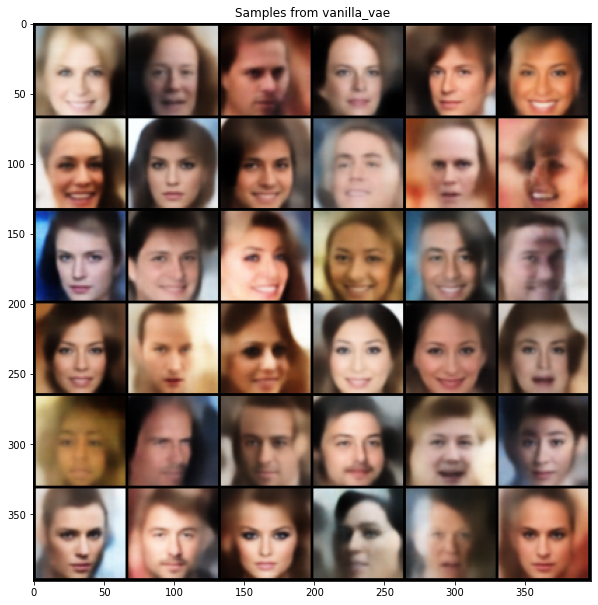

In [ ]:
num_imgs = 36
num_of_images_per_row
figsize_samples = (10, 10)

vaes = make_and_load_models(["vanilla_vae"], use_gpu=True)
plot_samples(vaes, num=num_imgs, num_of_images_per_row=num_of_images_per_row)

One solution they propose is to use a 2 VAE trained using the latent vectors of the first as a target to learn the correct probability measure on the initial manifold learnt by the first VAE. Image samples are then taken by first sampling a new latent vector from this secondary VAE and then passing it to the decoder from the first VAE. The result is images with fewer artefacts than the initial vanilla VAE. 

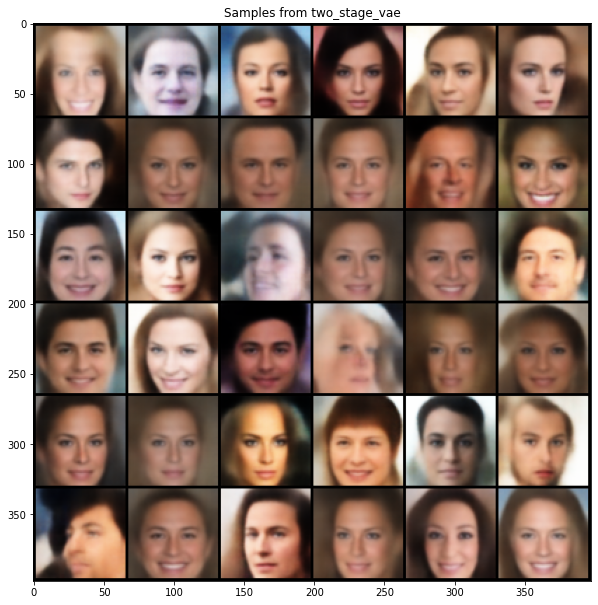

In [ ]:
num_imgs = 36
num_of_images_per_row
figsize_samples = (10, 10)

vaes = make_and_load_models(["two_stage_vae"], use_gpu=True)
plot_samples(vaes, num=num_imgs, num_of_images_per_row=num_of_images_per_row)

## 4. Try adding free bits to create better reconstructions with fewer details losses.

One way to prevent posterior collapse is to lower bound the KL term in the ELBO, i.e. 

$$\mathbb{KL}(q(z\mid x) \mid\mid p_\theta(z)) > \delta$$

to prevent it from decreasing to 0 and completely ignoring the latent code. One way of achieving this is to rewrite the KL term to include a hinge loss term [Kingma et al. 16](https://arxiv.org/pdf/1606.04934.pdf).

$$\frac{1}{2}||\hat{x} - x||^2- \max(\mathbb{KL}(q(z\mid x) \mid\mid p_\theta(z)), \delta)$$

Hence, when the KL term falls below a certain value, it no longer has any incentive to decrease it, preventing the KL term from dropping to 0.

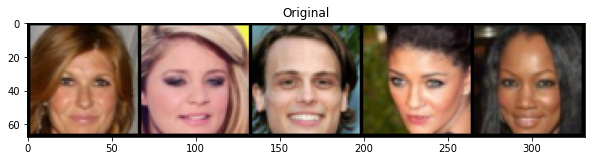

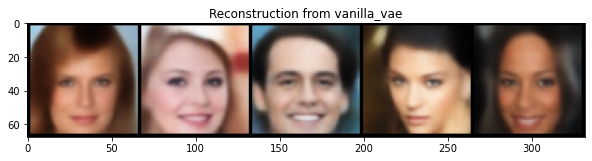

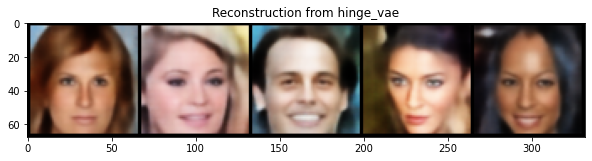

In [ ]:
models_to_compare = ["vanilla_vae", "hinge_vae"]
figsize_reconstruction = (10, 30)
num_imgs = 5

vaes = make_and_load_models(models_to_compare, use_gpu=True)
plot_reconstruction(vaes, batch, num_of_samples=num_imgs)

A similar motivation is used in delta-VAE, but in delta-VAE ([Razavi et al. 19](https://arxiv.org/pdf/1901.03416.pdf)), restrictions are placed on the variational family of the VAE, i.e. placing bounds on possible the min and max of the mean and variance of the posterior distribution. Similarly, other works [Xu et al. 18](https://arxiv.org/pdf/1808.10805.pdf) have explored using von Mises fisher prior and posterior instead of gaussian for a similar effect. 

## 5. Use ideas from vector quantisation to avoid posterior collapse

Another approach to improving reconstructions is to use discrete latent codes by quantising the latent code of the VAE allowing us to expliot techniques such vector quantisation to avoid posterior collapse, this method is known as vector qunatised VAE or vq vae [(oord et al 17)](https://arxiv.org/pdf/1711.00937.pdf). A diagram of the model is shown below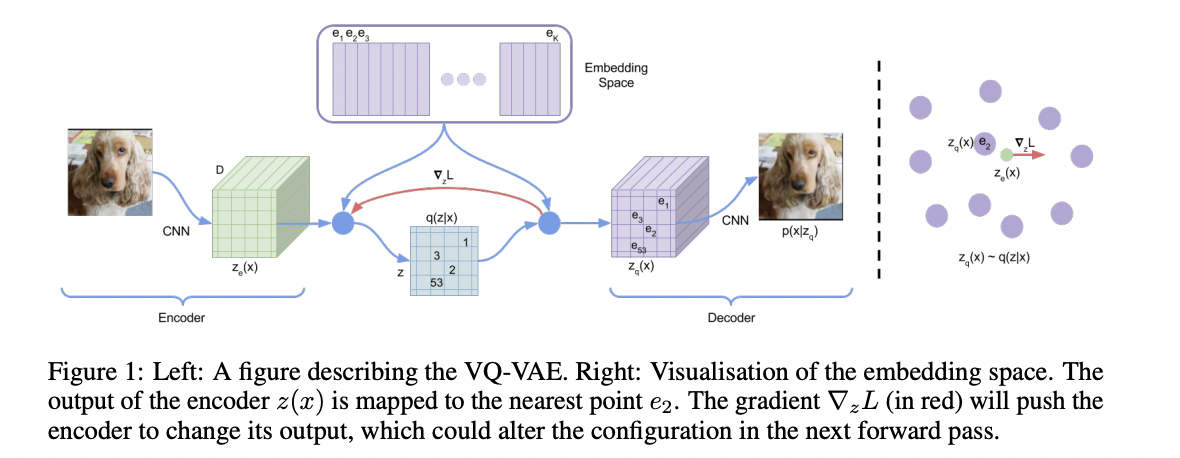

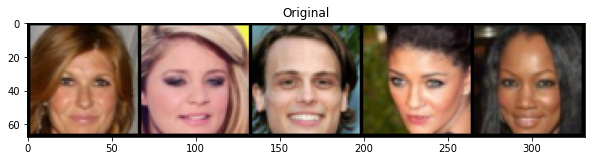

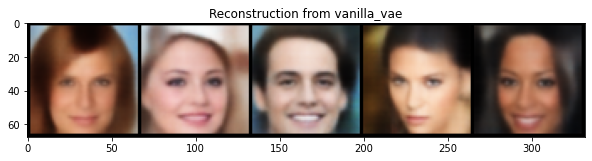

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


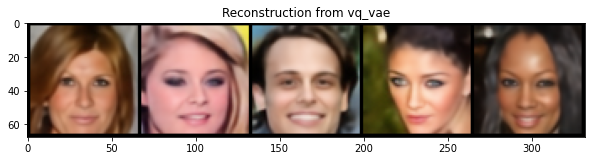

In [ ]:
models_to_compare = ["vanilla_vae", "vq_vae"]
figsize_reconstruction = (10, 30)
num_imgs = 5

vaes = make_and_load_models(models_to_compare, use_gpu=True)
plot_reconstruction(vaes, batch, num_of_samples=num_imgs)

The high quality reconstructions also allow interpolation between 2 existing images without too much loss of detail.

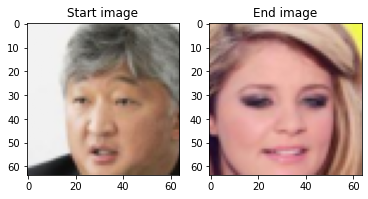

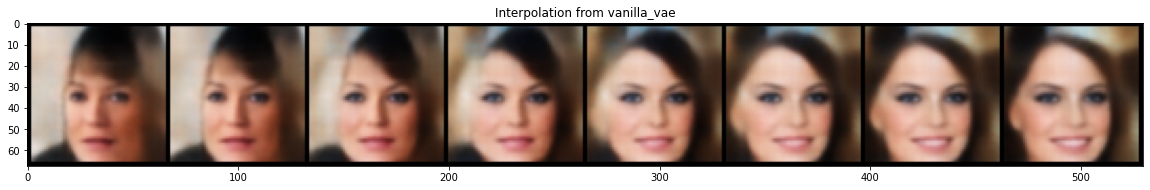

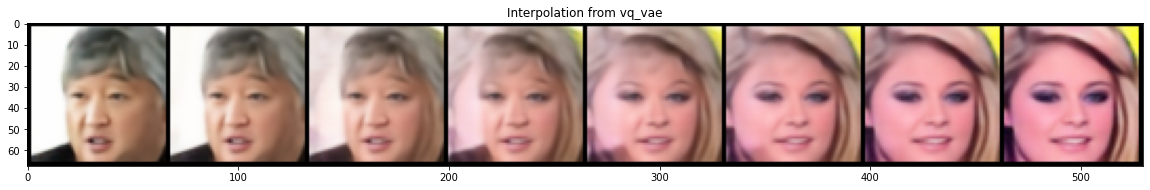

In [ ]:
from einops import rearrange

feature_of_interest = "Male"
vec3, male, female = vector_of_interest(vaes[0], batch, feature_of_interest)

start_img = torch.reshape(male[1], [1, 3, 64, 64])
end_img = torch.reshape(female[1], [1, 3, 64, 64])

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Start image")
axs[0].imshow(rearrange(start_img, "b c h w -> h w (c b)"))
axs[1].imshow(rearrange(end_img, "b c h w -> h w (c b)"))
axs[1].set_title("End image")
plt.show()

for vae in vaes:
    plt.figure(figsize=(20, 10))
    plt.title(f"Interpolation from {vae.model_name}")
    arr = get_imrange(vae.decode, vae.det_encode(start_img), vae.det_encode(end_img), nums=8, interpolation="linear")
    plt.imshow(arr)